In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import argparse
import copy

plt.style.use('sarah_plt_style.mplstyle')

Lets use a non-ideal example image (includes other objects in the image, has some uneven brightness across the image, and does not have constant/periodic behavior across the image)

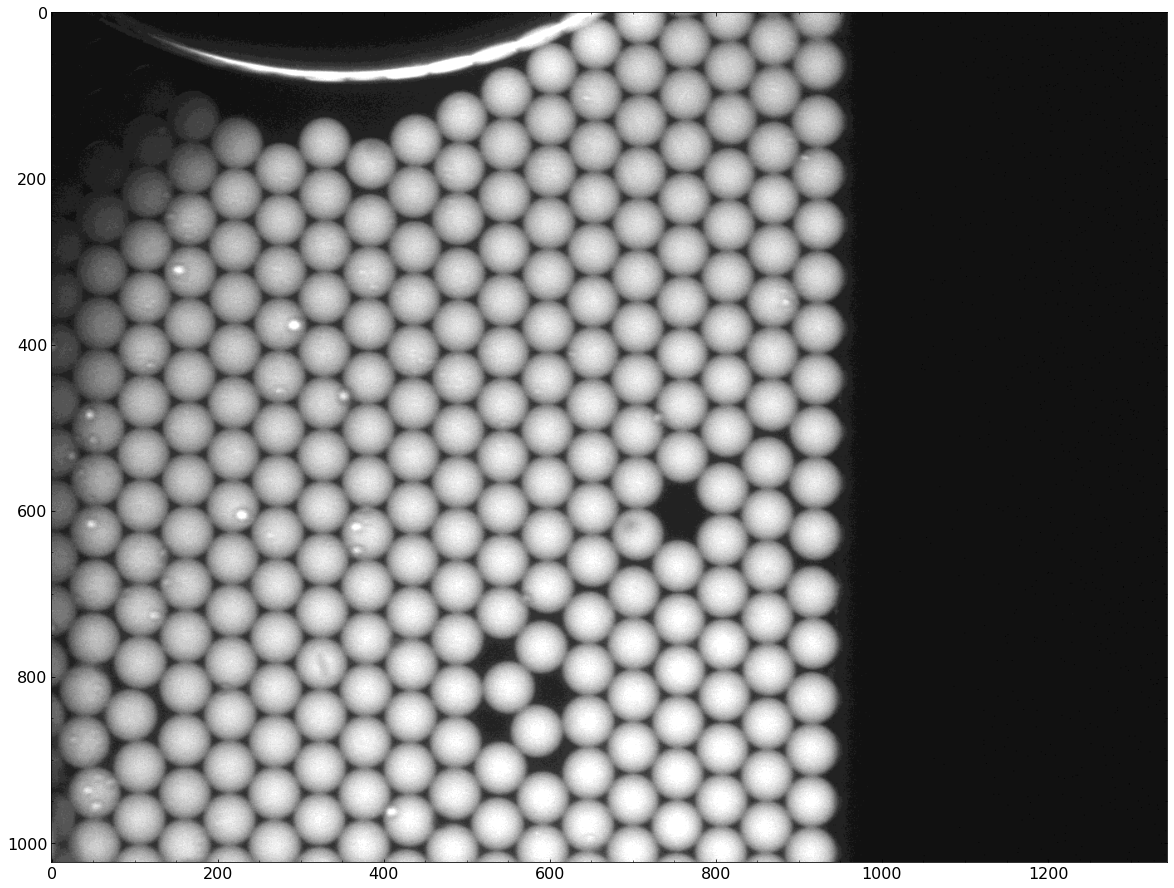

In [2]:
#change and get current working directory (cwd)
os.chdir('{}\Images'.format(os.getcwd()))
image_dir = os.getcwd()

#load the image in a format compatible with HoughCircles
image = cv.imread('{}\\20220818\example_image.tif'.format(image_dir), 0)

fig, ax = plt.subplots(figsize = (20, 20))
ax.imshow(image, cmap = 'gray')
plt.show()

Note: for the sake of cleanliness of brevity of code, the majority of important things are kept in the following python cell. As changes were made as describe below, those changes were made to this cell. Therefore many of the functions defined here are not used until much later, but this allows us to avoid repeat code and to more conveniently convert this to a script format once finalized. 

In [23]:
def find_pixels_in_circle(cir_par):
    #returns a list of points inside a circle with a given center point and radius
    #does not include any points which are off the edge of the image
    points = []
    cx, cy, r = cir_par
    for y in range(-1 *  r, +r+1):
        x = (r**2 - y**2)**0.5

        x1 = int(-x + cx)
        x2 = int(+x + cx)
    
        y = y + cy
        for x in range(x1, x2):
            if x < 1344 and y < 1024: #don't keep a point if it falls outside the image size
                points.append([x,y])
    return points 

class droplet_image:
    def binerize(self, cutoff):
        #binerize the imagep
        _, bin_image = cv.threshold(self.image, cutoff, 1, cv.THRESH_BINARY)
        return bin_image

    def find_circles(self, image_to_search):
        #find circles using a Hough transform
        circles = cv.HoughCircles(image_to_search, cv.HOUGH_GRADIENT, dp =1, minDist = 50, param1=1, param2=1, maxRadius = 50)
        circles = np.uint16(circles)
        return circles[0,:]

    def get_overlay_image(self, image_to_overlay, circle_set):
        #create a color version of the gray scale image to be able to plot circles over
        image_to_overlay = cv.cvtColor(image_to_overlay, cv.COLOR_GRAY2BGR)
        for i in circle_set: #for each found circle
            cv.circle(image_to_overlay,(i[0],i[1]),i[2],(0,255,0),2) #add a green outline to the color image
            cv.circle(image_to_overlay,(i[0],i[1]),2,(0,0,255),3) #add a blue center point to the color image
        return image_to_overlay

    def filter_circles(self, circle_set, average_value_cutoff, image_to_get_values):
        filtered_circles = []
        for i in circle_set: #for each found circle
            points = find_pixels_in_circle(i) #list off all points in the circle
            values = [image_to_get_values[point[1], point[0]] for point in points] #list of pixel vales in the binary image at those points
            if np.mean(values) > average_value_cutoff:
                filtered_circles.append(i)
        return filtered_circles

    def __init__(self, array, bin_cutoff):
        self.image = array
        self.bin_image = self.binerize(bin_cutoff)
        self.circles = self.find_circles(self.bin_image)
        self.filtered_circles = self.filter_circles(self.circles, 0.9, self.bin_image)
        self.radi = [cir[2] for cir in self.filtered_circles]

HoughCircles appears to be the standard for using python to find circles in images, but it is pretty sensitive to the overall patterns of the image. For example it will pretty often put a circle around a whole group of droplets. THe only way I was able to get it to semi-consistently find droplets was to lower the maxRadius to 30, which defeats the point. If I simplify the image by binerizing it however, it does a great job of finding most of the droplets and getting actuate radi.

In [24]:
test_droplet_image = droplet_image(image, 6) #initialize the class object
find_circles_og_image = test_droplet_image.get_overlay_image(test_droplet_image.image * 17, test_droplet_image.find_circles(test_droplet_image.image)) #find circles in the original image, and overlay them on the original image
find_circles_bin_image = test_droplet_image.get_overlay_image(test_droplet_image.bin_image * 200, test_droplet_image.circles) #find circles in the binerized image, and overlay them on the binerized image

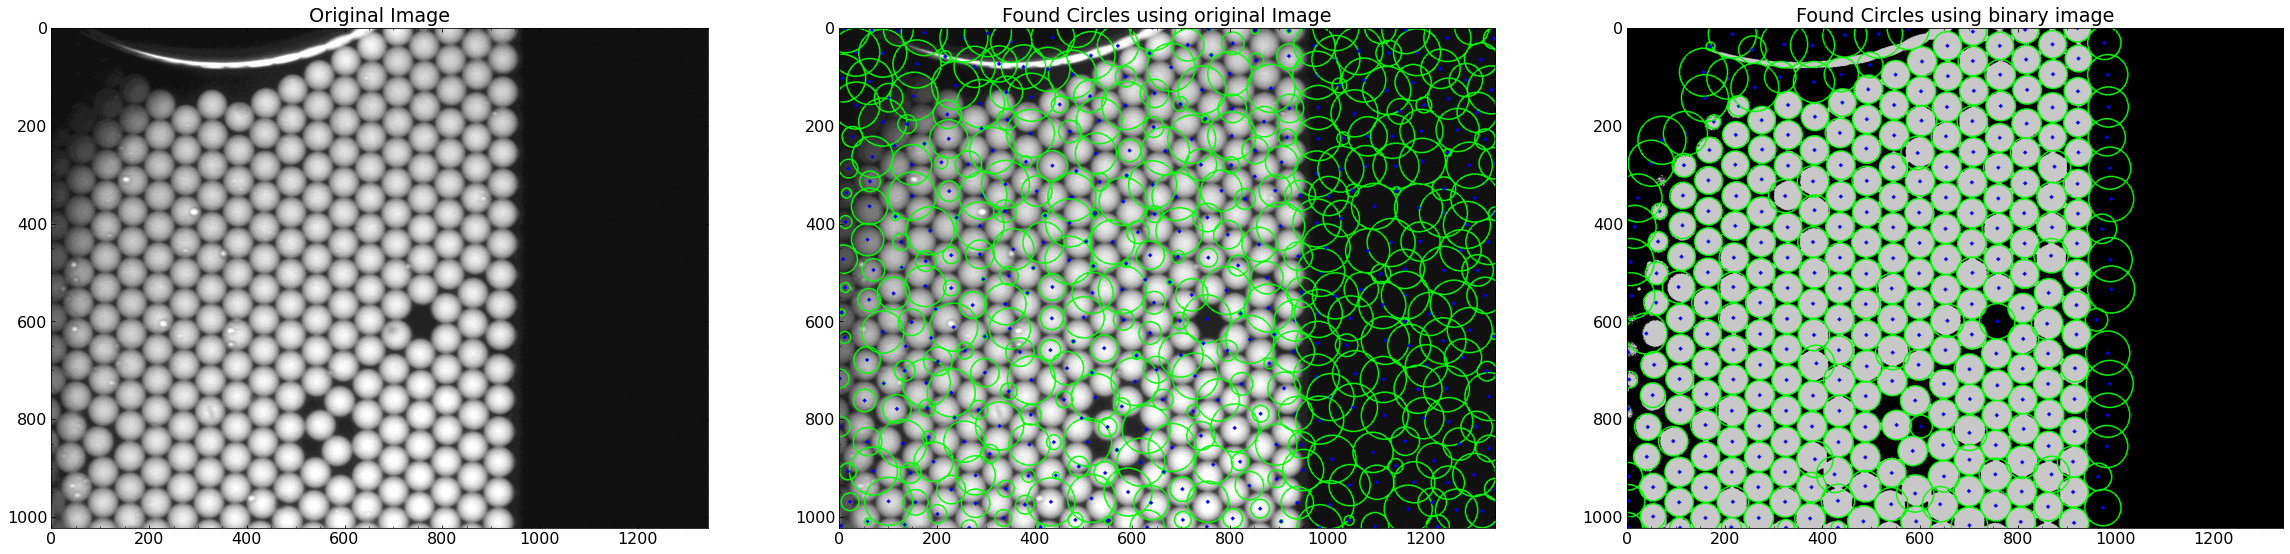

In [25]:
fig, axs = plt.subplots(1, 3, figsize = (40,20))
axs[0].imshow(image, cmap = 'gray')
axs[0].set_title('Original Image')
axs[1].imshow(find_circles_og_image, cmap = 'gray')
axs[1].set_title('Found Circles using original Image')
axs[2].imshow(find_circles_bin_image, cmap = 'gray')
axs[2].set_title('Found Circles using binary image')
plt.show()

Now we need to figure out how to filter out the extra circles that are not highlighting droplets. To do this we will find all of the points in a given circle, then find the average pixel value (in the binary image) and remove any circles with an average value less than 0.9.

In [26]:
found_circles = test_droplet_image.get_overlay_image(test_droplet_image.image * 17, test_droplet_image.circles) #find circles in the binerized image, and overlay them on the original image
filtered_found_circles = test_droplet_image.get_overlay_image(test_droplet_image.image * 17, test_droplet_image.filter_circles(test_droplet_image.circles, 0.9, test_droplet_image.bin_image)) #filter the circles using the values on the binary image

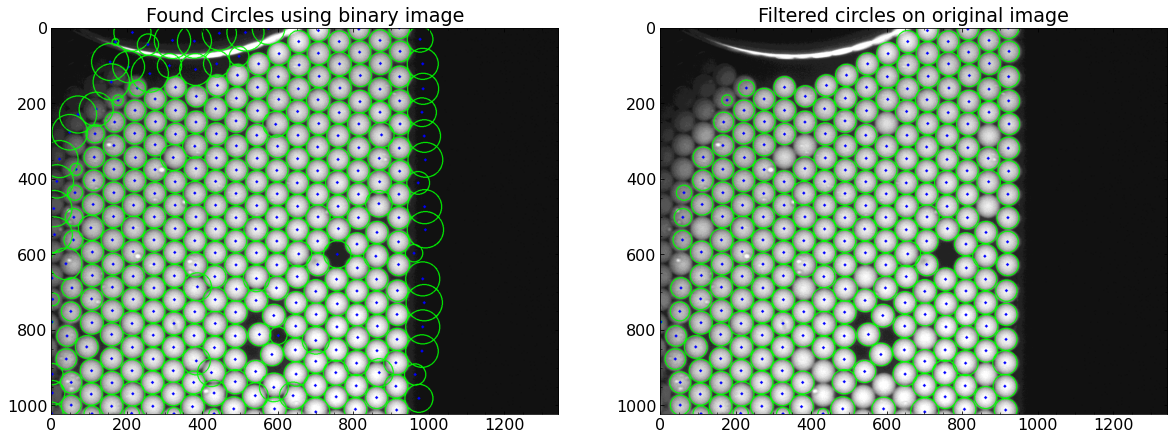

In [27]:
fig, axs = plt.subplots(1, 2, figsize = (20,10))

axs[0].imshow(found_circles, cmap = 'gray')
axs[0].set_title('Found Circles using binary image')
axs[1].imshow(filtered_found_circles, cmap = 'gray')
axs[1].set_title('Filtered circles on original image')

plt.show()

Nows lets plot the resulting radi

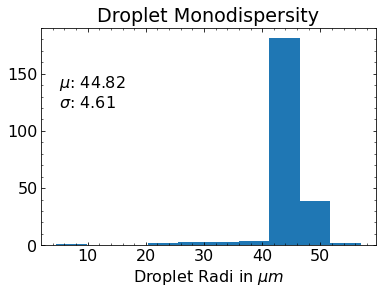

In [29]:
pixel_to_microns = 1000 / 650
radi_um = [i * pixel_to_microns for i in test_droplet_image.radi]
average_droplet_radi = np.mean(radi_um)
std_droplet_radi = np.std(radi_um)
plt.hist(radi_um)
plt.xlabel('Droplet Radi in $\mu m$')
plt.title('Droplet Monodispersity')
plt.text(5,120,'$\mu$: {:.2f}\n$\sigma$: {:.2f}'.format(average_droplet_radi, std_droplet_radi))
plt.show()